# TFY4280 Signal Analysis - programming assignment 2

by Øystein Hiåsen ([hiasen@stud.ntnu.no](mailto:hiasen@stud.ntnu.no))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Task 1 - RCL circuit

We are going to simulate an RCL circuit driven by a sinusoidal source.

This circuit can be simulated with the following differential equation.

$$v(t) = Ri(t) + L\frac{di(t)}{dt} + \frac{1}{C} \int_{-\infty}^t i(\tau) d\tau$$
or 
$$v(t) = Ri(t) + L\frac{di(t)}{dt} + \frac{1}{C} \left(\int_0^t i(\tau) d\tau + Q_0\right)$$
where $Q_0$ is the charge on the capacitor at time $t=0$.

By taking the Laplace transform of this we get:
$$V(s) = RI(s) + L(sI(s) - i(0)) + \frac{1}{C} \left(\frac{I(s)}{s} + \frac{Q_0}{s}\right)$$

Rearranging this with respect to $I(s)$ we get
$$ I(s) = \frac{Cs}{LCs^2 + RCs + 1} V(s) + \frac{LCi(0) s - Q_0}{LCs^2 + RCs + 1}.$$

This can also be written as
$$ I(s) =  I_{zs}(s)+ I_{zi}(s) $$
where
$$ I_{zi}(s) = \frac{LCi(0) s - Q_0}{LCs^2 + RCs + 1}  $$
is the laplace transform of the response of the system for zero input
and 
$$ I_{zs}(s) = H(s) V(s) $$
is the response for zero initial state.
Here 
$$ H(s) = \frac{Cs}{LCs^2 + RCs + 1}$$
is the transfer function of the system.


In [10]:
from scipy.signal import lti
from matplotlib import pyplot as plt
# Setting up the parameters
R = 15 # Ohm
C = 333e-6 # Farad
L = 16e-3 # Henry


# create the system using the numerator 
# and the denominator of the transfer function.
num = [C, 0]
den = [L*C, R*C, 1]
rcl_system = lti(num, den)

# Setting parameters for the input signal
freq = 60 # Hz
angular_freq = 2*np.pi*freq # 1/s
phi = np.deg2rad(25) # radians
V0 = np.sqrt(2) * 110 # volt

# create the input-signal
time_duty1 = np.linspace(0, 0.05, 10000) # s
signal_duty1 = V0 * np.cos(angular_freq * time_duty1 + phi)

In the first case the energy in the system is zero and consequently 
$Q_0 = 0$ and $i(0) = 0$.

This means that the system is only driven by the transfer function, that is we have only the zero state response.

In [50]:
(_,
 signal_response,
 _) = rcl_system.output(U=signal_duty1,
                        T=time_duty1)

In the second case $Q_0 = 0.66 \mathrm{C}$ and we assume that the current is initially zero, $i(0)=0$.
So we can set the zero input response to be
$$ I_{zi}(s) = \frac{ - Q_0}{LCs^2 + RCs + 1}  $$
and compute the inverse laplace transform of it and add it to the response of the signal.

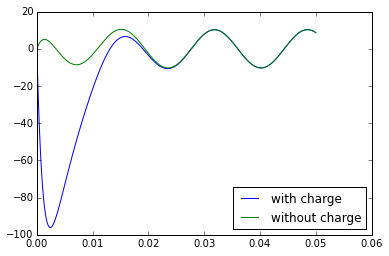

In [55]:
from scipy.signal import impulse
Q0 = 0.66 # coulomb
t, zero_signal_response = impulse([[-Q0], den], T=time_duty1)
full_response_with_charge = zero_signal_response + signal_response

# plot both cases together
plt.plot(t, full_response_with_charge, label="with charge")
plt.plot(t, signal_response, label="without charge")
plt.legend(loc="lower right")

## Task 2 - Generation of different pulses

In [56]:
# Making the time vector to use for all the pulses
sample_frequency = 10000 # Hz
time_step = 1/sample_frequency # seconds
time_vector_length = 3 # seconds
time = np.arange(0, time_vector_length, time_step) # seconds

### 1 Rectangular pulse

In [57]:
# Setting some parameters that will be used for
# both the rectangular pulse and the triangular pulse
pulse_length = 10e-3 # s
amplitude = 1
centered_around = 1 # s

# Finding the positions of the pulse
pulse_middle = centered_around * sample_frequency
num_samples_in_pulse = pulse_length * sample_frequency
num_samples_in_half_pulse_width = pulse_length/2 * sample_frequency

pulse_start = pulse_middle - num_samples_in_pulse / 2
pulse_end = pulse_middle + num_samples_in_pulse / 2

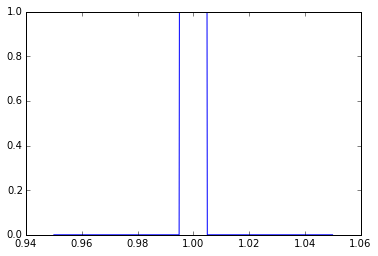

In [58]:
# Create the rectangular pulse using the previously created timevector
rectangular_pulse = np.zeros(time.size)
rectangular_pulse[pulse_start:pulse_end] = 1

# Plot the pulse
plotting_slice = slice(0.95*sample_frequency, 1.05*sample_frequency)
the_plot = plt.plot(time[plotting_slice],
                    rectangular_pulse[plotting_slice])

### 2 Triangular pulse

In [59]:
# Here we are using the same parameters as for the rectangular pulse

triangular_pulse = np.zeros(time.size)
triangular_pulse[pulse_start:pulse_middle] = np.linspace(0, amplitude, pulse_middle-pulse_start)
triangular_pulse[pulse_middle:pulse_end] = np.linspace(amplitude, 0, pulse_end - pulse_middle)

# Plot the pulse
plotting_slice = slice(0.95*sample_frequency, 1.05*sample_frequency)
plt.plot(time[plotting_slice],
         triangular_pulse[plotting_slice])

### 3 -  Gaussian pulse

In [60]:
gaussian_pulse = np.zeros(time.size)

gauss_width = 3e-3 # seconds
gauss_width_samples = gauss_width * sample_frequency

gauss_pulse_interval = slice(pulse_middle-gauss_width_samples/2, pulse_middle+gauss_width_samples/2)
x = np.linspace(0, gauss_width, gauss_width_samples)
gaussian_pulse[gauss_pulse_interval] = np.exp(-((x - gauss_width/2)/(gauss_width/6))**2/2)

# plot the pulse
plotting_slice = slice(0.99*sample_frequency, 1.01*sample_frequency)
plt.plot(time[plotting_slice],
         gaussian_pulse[plotting_slice])

### 4 - A sequence of 11 rectangular pulses of width 1ms separated by 9 ms starting at t=1s

In [61]:
# Initialize empty vector of same size as time vector
sequence_of_rect_pulses = np.zeros(time.size)

# Parameters of pulses in real units
num_pulses = 11
start_time = 1 # s
time_period = 10e-3 # s
pulse_width = 1e-3 # s (1ms)

# Sample information
width = int(pulse_width * sample_frequency)
start = int(start_time * sample_frequency)
period = int(time_period * sample_frequency)

start_points = range(start, start + period*num_pulses, period)
for s in start_points:
    sequence_of_rect_pulses[s:s+width] = 1

In [62]:
plt.plot(time, sequence_of_rect_pulses)
plt.xlim([0.99, 1.105])

(0.99, 1.105)

## Task 3

$$X(s) = \frac{2s+1}{(s+2)(s+3)} = \frac{2s+1}{s^2+5s+6}$$

$$Y(s) = \frac{5s^2 - 3s +2}{(s+1)(s^2+2s+7)} = \frac{5s^2 - 3s +2}{s^3 +3s^2 + 9s + 7}$$

$$Z(s) = \frac{1+ e^{-3s}}{s(2s+5)} = \frac{1+ e^{-3s}}{2s^2+5s} $$

In [64]:
# Setting the numerators and denominators of the above
num_X = [2, 1]
den_X = [1, 5, 6]

num_Y = [5, -3, 2]
den_Y = [1, 3, 9, 7]

num_Z = [1]
den_Z = [2, 5, 0]

In [142]:
from scipy.signal import residue, lti, convolve, fftconvolve

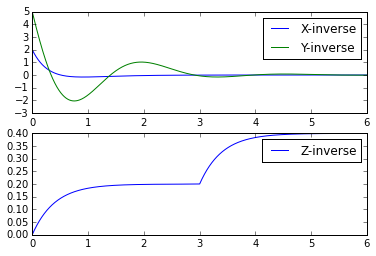

In [130]:
# Finding the roots 
roots_X, poles_X, k_X = residue(num_X, den_X)
roots_Y, poles_Y, k_Y = residue(num_Y, den_Y)
roots_Z, poles_Z, k_Z = residue(num_Z, den_Z)

time3 = np.arange(0, 6, 1/sample_frequency)
# Overly complicated way of doing it (could have done it using lti.impulse),
# but wanted to see if it worked
from itertools import zip_longest
inverse_X = sum([r*np.exp(p*time3) for r,p in zip_longest(roots_X, poles_X, fillvalue=0)])
inverse_Y = sum([(r*np.exp(p*time3)).real for r,p in zip_longest(roots_Y, poles_Y, fillvalue=0)])

inverse_Z1 = sum([r*np.exp(p*time3) for r,p in zip_longest(roots_Z, poles_Z, fillvalue=0)])
inverse_Z2 = sum([r*np.exp(p*(time3-3)) for r,p in zip_longest(roots_Z, poles_Z, fillvalue=0)])
inverse_Z2[time3<3] = 0
inverse_Z = inverse_Z1 + inverse_Z2

plt.title()
plt.subplot(2,1,1)
plt.plot(time3, inverse_X, label="X-inverse")
plt.plot(time3, inverse_Y, label="Y-inverse")
plt.legend()
plt.subplot(2,1,2)
plt.plot(time3, inverse_Z, label="Z-inverse")
plt.legend()

In [116]:
# Create the system
sys_X = lti(num_X, den_X)
sys_Y = lti(num_Y, den_Y)
sys_Z = lti(num_Z, den_Z)

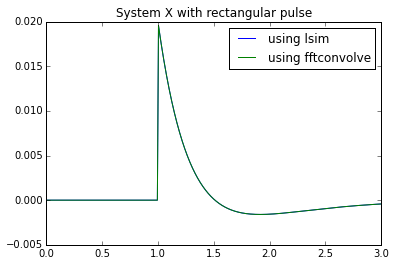

In [145]:
_, yout, _ = sys_X.output(rectangular_pulse, time)
y_convolved = fftconvolve(rectangular_pulse, inverse_X, mode="full")/sample_frequency
plt.plot(time, yout, label="using lsim")
plt.plot(time, y_convolved[:len(time)], label="using fftconvolve")
plt.title("System X with rectangular pulse")
plt.legend()

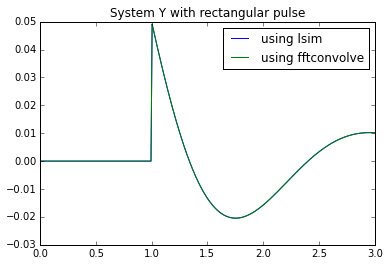

In [148]:
_, yout, _ = sys_Y.output(rectangular_pulse, time)
y_convolved = fftconvolve(rectangular_pulse, inverse_Y, mode="full")/sample_frequency
plt.plot(time, yout, label="using lsim")
plt.plot(time, y_convolved[:len(time)], label="using fftconvolve")
plt.title("System Y with rectangular pulse")
plt.legend()

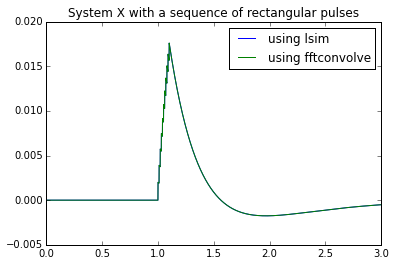

In [150]:
_, yout, _ = sys_X.output(sequence_of_rect_pulses, time)
y_convolved = fftconvolve(sequence_of_rect_pulses, inverse_X, mode="full")/sample_frequency
plt.plot(time, yout, label="using lsim")
plt.plot(time, y_convolved[:len(time)], label="using fftconvolve")
plt.title("System X with a sequence of rectangular pulses")
plt.legend()

In [152]:
_, yout, _ = sys_X.output(triangular_pulse, time)
y_convolved = fftconvolve(triangular_pulse, inverse_X, mode="full")/sample_frequency
plt.plot(time, yout, label="using lsim")
plt.plot(time, y_convolved[:len(time)], label="using fftconvolve")
plt.title("System X with triangular pulse")
plt.legend()

In [156]:
#_, yout1, _ = sys_Z.output(gaussian_pulse, time)
#_, yout2, _ = sys_Z.output(gaussian_pulse, time-3)
#yout2[time<3] = 0
#yout = yout1 + yout2

y_convolved = fftconvolve(gaussian_pulse, inverse_Z, mode="full")/sample_frequency
#plt.plot(time, yout, label="using lsim")
plt.plot(time3, y_convolved[:len(time3)], label="using fftconvolve")
plt.title("System Z with gaussian pulse")
plt.legend()

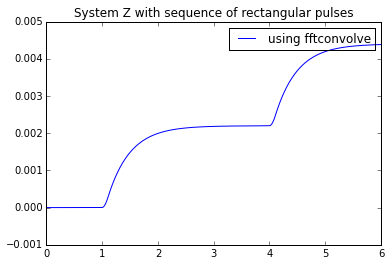

In [162]:
#_, yout1, _ = sys_Z.output(sequence_of_rect_pulses, time)
#_, yout2, _ = sys_Z.output(gaussian_pulse, time-3)
#yout2[time<3] = 0
#yout = yout1 + yout2

y_convolved = fftconvolve(sequence_of_rect_pulses, inverse_Z, mode="full")/sample_frequency
#plt.plot(time, yout, label="using lsim")
plt.plot(time3, y_convolved[:len(time3)], label="using fftconvolve")
plt.title("System Z with sequence of rectangular pulses")
plt.legend()

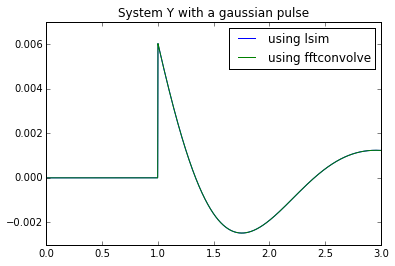

In [164]:
_, yout, _ = sys_Y.output(gaussian_pulse, time)
y_convolved = fftconvolve(gaussian_pulse, inverse_Y, mode="full")/sample_frequency
plt.plot(time, yout, label="using lsim")
plt.plot(time, y_convolved[:len(time)], label="using fftconvolve")
plt.title("System Y with a gaussian pulse")
plt.legend()